<a href="https://colab.research.google.com/github/jvataidee/PesquisaOperacional/blob/master/otimiza%C3%A7%C3%A3o_caraga_caminh%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<p align="center"><img src="https://static.wixstatic.com/media/bdd7cb_6ecb6c85550043f090237e5943d2647c~mv2.png/v1/fill/w_417,h_88,al_c,q_85,usm_0.66_1.00_0.01/Ativo%2023-8.webp" height="75px"></p>

**by: [João Ataíde](https://www.joaoataide.com)**
# **Otimização da Carga de um caminhão**


---


<p align="center"><img src="https://static.wixstatic.com/media/bdd7cb_c37cf789f470415781495054582faa05~mv2.jpg"></p>




In [1]:
!pip install deap -q

     |████████████████████████████████| 163kB 14.3MB/s 


In [2]:
import numpy as np
import random
import pandas as pd
from deap import base, creator, algorithms, tools
import matplotlib.pyplot as plt

## Importando os dados

In [3]:
!pip install kaggle -q

In [ ]:
from google.colab import files
files.upload()

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d olistbr/brazilian-ecommerce

 59% 25.0M/42.7M [00:00<00:00, 23.1MB/s]
100% 42.7M/42.7M [00:00<00:00, 46.3MB/s]


In [10]:
!ls

brazilian-ecommerce.zip  kaggle.json  sample_data


In [11]:
import zipfile
zip_ref = zipfile.ZipFile('brazilian-ecommerce.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [17]:
df_items = pd.read_csv('/content/files/olist_order_items_dataset.csv')
df_produto = pd.read_csv('/content/files/olist_products_dataset.csv')

In [13]:
print(df_items.shape)
df_items.head()

(112650, 7)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [15]:
print(df_produto.shape)
df_produto.head()

(32951, 6)


,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,625.0,20.0,17.0,13.0


### Prepararo do dataset

In [18]:
#Escolher variáleis as necesárias
df_items = df_items.iloc[:, [2,5,6]]
df_produto = df_produto.iloc[:, [0,1,5,6,7,8]]

In [19]:
#Indexar o id do produto
df_items = df_items.set_index('product_id')
df_produto = df_produto.set_index('product_id')

In [20]:
 #Realizar um join entre as tabelas
 df = df_items.join(df_produto)

In [21]:
#Calcular o volume e preço total de cada produto
df["volume"] = df["product_length_cm"]*df["product_height_cm"]*df["product_width_cm"]
df["preco"] =  df["price"]+df["freight_value"]
df = df.reset_index()

In [24]:
#Escolher dataset final
produtos = df.iloc[:, [0,3, 4 ,8,9]]
produtos.head()

,product_id,product_category_name,product_weight_g,volume,preco
0,00066f42aeeb9f3007548bb9d3f33c38,perfumaria,300.0,5120.0,120.24
1,00088930e925c41fd95ebfe695fd2655,automotivo,1225.0,14300.0,143.83
2,0009406fd7479715e4bef61dd91f2462,cama_mesa_banho,300.0,23625.0,242.10
3,000b8f95fcb9e0096488278317764d19,utilidades_domesticas,550.0,5472.0,78.50
4,000b8f95fcb9e0096488278317764d19,utilidades_domesticas,550.0,5472.0,78.50


## Criando o Algoritimo Genético

Tipo de caminhão VUC
<p align="center"><img src="http://www.guiadotrc.com.br/figuras/vuc-reforcado.gif?gtgggf"></p>



<p align="center"><img src="https://www.truckpad.com.br/uploads/2017/01/329981fc-medidas-carrocerias-3.png"></p>

In [25]:
#lmimte de espaço no caminhão
limtie_espacos = 2.2*7.2*3.5*100  #grandeza em centimetros
limtie_peso = 4e+6   #grandeza em gramas

In [26]:
#Criar Classe do Produto
class Produto():
    def __init__(self, nome, pesos, volume, valores):
        self.nome = nome
        self.pesos = pesos 
        self.volume = volume
        self.valor = valor

In [27]:
#Criando listas de produtos
lista_produtos = []

for i in range(len(produtos)):
  lista_produtos.append(produtos.loc[i])

In [28]:
#Transformar em listas
espacos = list(produtos.volume)
valores = list(produtos.preco)
nome = list(produtos.product_id)
pesos = list(produtos.product_weight_g)

In [29]:
#Criar a função de avaliação
def avaliacao(individual):
    nota = 0 
    soma_espacos = 0
    soma_pesos = 0

    for i in range(len(individual)):
        if individual[i] == 1:
            nota += valores[i]
            soma_espacos += espacos[i]
            soma_pesos += pesos[i]
            
    if soma_espacos > limtie_espacos and soma_pesos > limtie_peso:
      nota = 1

    return nota / 100000, 

In [30]:
#Criar a toolbox
toolbox = base.Toolbox()

#Criando parâmetros na toolbox
creator.create("FitnessMax",  base.Fitness, weights = (1.0, ))
creator.create("Individual", list, fitness = creator.FitnessMax)

#Registrando na toolbox
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n = len(espacos))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", avaliacao)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb = 0.05)
toolbox.register("select", tools.selRoulette)

In [31]:
#Iniciando a toolbox
if __name__ == "__main__":
    population = toolbox.population(n = 20)
    probabilidade_crossover = 1.0
    probabilidade_mutação = 0.03
    numero_gerações = 150
    
    estatisticas = tools.Statistics( key = lambda individuo: individuo.fitness.values)
    estatisticas.register("max", np.max)
    estatisticas.register("min", np.min)
    estatisticas.register("med", np.mean)
    estatisticas.register("std", np.std)
    
    populacao, info = algorithms.eaSimple(population, toolbox, 
                                          probabilidade_crossover, 
                                          probabilidade_mutação,
                                          numero_gerações, estatisticas)

gen	nevals	max    	min    	med    	std     
0  	20    	80.0468	78.7032	79.2306	0.379616
1  	20    	79.873 	78.5366	79.2815	0.370427
2  	20    	79.9693	78.4649	79.4077	0.330098
3  	20    	79.9693	78.4667	79.4339	0.383112
4  	20    	79.9693	78.6045	79.4911	0.348458
5  	20    	79.973 	78.5914	79.4665	0.332479
6  	20    	80.0676	78.949 	79.5165	0.290608
7  	20    	79.7261	79.083 	79.455 	0.192927
8  	20    	79.6711	79.0966	79.3721	0.150348
9  	20    	79.7333	79.0604	79.3808	0.192083
10 	20    	79.819 	78.8407	79.3735	0.254834
11 	20    	79.8723	78.8378	79.3378	0.31119 
12 	20    	79.667 	78.4555	79.2559	0.334676
13 	20    	80.0535	78.4555	79.193 	0.488592
14 	20    	79.7208	78.4555	79.1592	0.376187
15 	20    	79.7531	78.3433	79.3186	0.340484
16 	20    	79.8694	78.9302	79.3819	0.244607
17 	20    	80.0481	78.7992	79.3301	0.308162
18 	20    	80.0481	78.8432	79.4941	0.332397
19 	20    	80.0481	78.7241	79.5212	0.307648
20 	20    	80.0481	78.9304	79.5812	0.29538 
21 	20    	80.1253	78.7691	79.50

In [38]:
#Identificando o melhor indivíduo
melhores = tools.selBest(populacao, 1)

for individuo in melhores:
    print("---")
    print ("Indivíduo", individuo)
    print ("Valor do Fitness", individuo.fitness)
    print("---")

    df_otimizado = []
    soma = 0
    indi = 0
    for i in range (len(lista_produtos)):
        if individuo[i] == 1:
            soma += valores[i]
            indi += individuo[i]
            df_otimizado.append(lista_produtos[i])

    print("---")
    print("Valor total do Indivíduo: R$", soma)
    print("Número Indivíduo:", indi)

---
Indivíduo [0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0

In [40]:
df_otimizado = pd.DataFrame(df_otimizado)
df_otimizado.head()

,product_id,product_category_name,product_weight_g,volume,preco
3,000b8f95fcb9e0096488278317764d19,utilidades_domesticas,550.0,5472.0,78.50
5,000d9be29b5207b54e86aa1b1ac54872,relogios_presentes,250.0,3630.0,218.27
7,00126f27c813603687e6ce486d909d01,cool_stuff,700.0,1875.0,262.24
8,00126f27c813603687e6ce486d909d01,cool_stuff,700.0,1875.0,265.49
9,001795ec6f1b187d37335e1c4704762e,consoles_games,600.0,12000.0,47.62


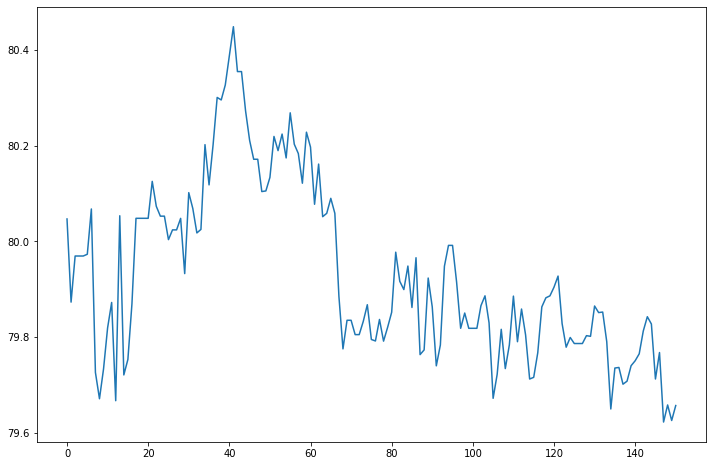

In [41]:
#Plotando o aprendizado
valores_pop = info.select("max")
plt.figure(figsize = (12,8))
plt.plot(valores_pop)
plt.show()